<a href="https://colab.research.google.com/github/Lu-David/CovariateShift/blob/main/Covariate_Shift_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python implementation of 2014 Liu Paper

https://proceedings.neurips.cc/paper/2014/file/d67d8ab4f4c10bf22aa353e27879133c-Paper.pdf

## Binary Classification

### Load Data

In [153]:
import scipy.io
import numpy as np
import os
import torch

folder_path = '/content' # TODO Upload data files and / or specify path

x_1 = scipy.io.loadmat(os.path.join(folder_path, 'x_1.mat'))['x_1']
x_2 = scipy.io.loadmat(os.path.join(folder_path, 'x_2.mat'))['x_2']
y_1 = np.transpose(scipy.io.loadmat(os.path.join(folder_path, 'y_1.mat'))['y_1'])
y_2 = np.transpose(scipy.io.loadmat(os.path.join(folder_path, 'y_2.mat'))['y_2'])

In [154]:
# source mean 
mu_s = [6, 6] 

# source variance
var_s = [[3, -2], [-2, 3]] 

# target mean
mu_t = [7, 7] 

# target variance
var_t = [[3, 2], [2, 3]] 

In [155]:
from scipy.stats import multivariate_normal

mvn_s = multivariate_normal(mu_s, var_s)
mvn_t = multivariate_normal(mu_t, var_t)

# Because we have expert knowledge on mu and var for both source and target, 
# we can get the predicted probabilities for each data point under source and target distributions 
d_s = mvn_s.pdf(x_1)
d_t = mvn_t.pdf(x_1)

In [156]:
r_ts = np.tile(np.reshape((d_t / d_s), (100, 1)), 2)
x_1_iw = x_1 * r_ts

In [196]:
x_1 = torch.FloatTensor(x_1)
x_2 = torch.FloatTensor(x_2)
y_1 = torch.FloatTensor(y_1)
y_2 = torch.FloatTensor(y_2)

In [199]:
x_1_sec = torch.cat((x_1, (x_1[:, 0] ** 2).unsqueeze(1), (x_1[:, 0] * x_1[:, 1]).unsqueeze(1), (x_1[:, 1] ** 2).unsqueeze(1)), dim =1)
x_2_sec = torch.cat((x_2, (x_2[:, 0] ** 2).unsqueeze(1), (x_2[:, 0] * x_2[:, 1]).unsqueeze(1), (x_2[:, 1] ** 2).unsqueeze(1)), dim =1)

### Logistic Regression (LR) and Importance Weighting (IW)

In [101]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import Adam

class LRClassifier(nn.Module):
    def __init__(self, in_features = 2, out_features = 1):
      super(LRClassifier, self).__init__()
      
      self.layer1 = nn.Linear(in_features, out_features)
      
      self.activation1 = nn.Sigmoid()

    def forward(self, input):
      return self.activation1(self.layer1(input))

In [143]:
def binaryLRTrain(X_s, y_s, r_ts, max_itr = 10000):

  lr_model = LRClassifier(in_features = X_s.shape[1])
  loss_fn = nn.BCELoss() 
  optimizer = torch.optim.Adam(lr_model.parameters(), lr = 0.01)
  for param in lr_model.parameters():
    param.data = nn.parameter.Parameter(torch.ones_like(param))

  lr_model.train()

  # convert labels from -1, 1 to 0, 1
  if -1 in y_s:
    y_s = torch.FloatTensor(np.where(y_s == 1, 1, 0))

  n_row, _ = X_s.shape

  X_s = X_s * r_ts
  
  for i in range(max_itr): 
      running_loss = 0.0
      optimizer.zero_grad()
      
      outputs = lr_model.forward(X_s)
      loss = loss_fn(outputs.squeeze(), y_s.squeeze())

      loss.backward()

      optimizer.step()

      if i % 1000 == 0:
        print(f"Loss at step {i}: {float(loss.data)}")

  return lr_model

In [115]:
model = binaryLRTrain(x_1_sec, y_1, torch.ones((len(x_1_sec), 1)))

Loss at step 0: 19.068561553955078
Loss at step 1000: 0.5310608148574829
Loss at step 2000: 0.43557366728782654
Loss at step 3000: 0.39726749062538147
Loss at step 4000: 0.38306552171707153
Loss at step 5000: 0.37863361835479736
Loss at step 6000: 0.3776043653488159
Loss at step 7000: 0.37725743651390076
Loss at step 8000: 0.37683531641960144
Loss at step 9000: 0.3762158453464508


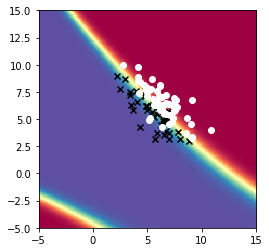

In [135]:
from matplotlib import markers
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

maxs = 15
mins = -5
 
X_dim1, X_dim2 = np.meshgrid(np.arange(mins, maxs + 0.1, 0.1), np.arange(mins, maxs + 0.1, 0.1))

dim = int((maxs - mins) / 0.1 + 1)

prediction = np.zeros((dim, dim))

for i in range(dim):
  for j in range(dim):
    
    x_t = torch.FloatTensor([X_dim1[i, j], X_dim2[i, j], X_dim1[i, j] ** 2, X_dim1[i, j] * X_dim2[i, j], X_dim2[i, j] ** 2]) / 10 # X_dim1[i, j] ** 2, X_dim1[i, j] * X_dim2[i, j], X_dim2[i, j] ** 2
    outputs = model(x_t).double()
    prediction[i, j] = outputs[0]
    

plt.imshow(prediction, cmap='Spectral', interpolation='nearest', origin='lower', extent=[-5, 15, -5, 15])

pos = x_1[np.array(y_1 == 1).flatten()]
neg = x_1[np.array(y_1 == -1).flatten()]

plt.scatter(pos[:,0], pos[:,1], marker="x", color="black")
plt.scatter(neg[:,0], neg[:,1], marker="o", color="white")

In [170]:
r_ts = np.tile(np.reshape((d_t / d_s), (100, 1)), 2)
(x_1 * r_ts).float() 

tensor([[5.6315e-02, 2.2233e-02],
        [2.9625e+00, 2.1157e+00],
        [2.7537e+00, 3.5105e+00],
        [1.0586e-01, 2.3099e-01],
        [4.4715e+00, 3.9502e+00],
        [5.8054e+00, 4.5030e+00],
        [3.4196e+00, 4.2582e+00],
        [1.4317e+00, 2.1474e+00],
        [2.1984e+00, 3.4802e+00],
        [5.3776e-02, 1.1600e-01],
        [6.0063e+00, 5.7338e+00],
        [5.0364e+00, 2.8357e+00],
        [6.7780e+00, 7.9286e+00],
        [3.6502e+00, 2.2956e+00],
        [3.7328e+00, 2.8451e+00],
        [5.1163e+00, 4.8933e+00],
        [1.1669e+02, 8.6550e+01],
        [4.4896e+00, 3.8099e+00],
        [8.5733e-03, 3.0641e-03],
        [1.2133e+00, 1.8246e+00],
        [5.1834e+00, 4.2815e+00],
        [3.8990e+00, 4.4904e+00],
        [1.5435e+00, 9.9138e-01],
        [6.9737e-01, 3.7066e-01],
        [2.1186e-04, 8.5489e-04],
        [2.6616e+00, 4.1696e+00],
        [9.6014e-01, 1.7348e+00],
        [1.6284e+01, 1.7643e+01],
        [7.7850e-02, 3.4264e-02],
        [3.780

In [168]:
iw_bin_model = binaryLRTrain(x_1_iw, y_1, torch.ones((len(x_1), 1)))

Loss at step 0: 15.914134979248047
Loss at step 1000: 0.6314664483070374
Loss at step 2000: 0.6309084296226501
Loss at step 3000: 0.6309014558792114
Loss at step 4000: 0.6309013962745667
Loss at step 5000: 0.6309013962745667
Loss at step 6000: 0.6309014558792114
Loss at step 7000: 0.6309014558792114
Loss at step 8000: 0.6309014558792114
Loss at step 9000: 0.6309014558792114


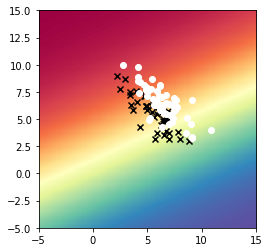

In [169]:
from matplotlib import markers
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

maxs = 15
mins = -5
 
X_dim1, X_dim2 = np.meshgrid(np.arange(mins, maxs + 0.1, 0.1), np.arange(mins, maxs + 0.1, 0.1))

dim = int((maxs - mins) / 0.1 + 1)

prediction = np.zeros((dim, dim))

for i in range(dim):
  for j in range(dim):
    
    x_t = torch.FloatTensor([X_dim1[i, j], X_dim2[i, j]]) # X_dim1[i, j] ** 2, X_dim1[i, j] * X_dim2[i, j], X_dim2[i, j] ** 2
    outputs = iw_bin_model(x_t)
    prediction[i, j] = outputs[0]

plt.imshow(prediction, cmap='Spectral', interpolation='nearest', origin='lower', extent=[-5, 15, -5, 15])

pos = x_1[np.array(y_1 == 1).flatten()]
neg = x_1[np.array(y_1 == -1).flatten()]

plt.scatter(pos[:,0], pos[:,1], marker="x", color="black")
plt.scatter(neg[:,0], neg[:,1], marker="o", color="white")

In [ ]:
rba_bin_model = binaryLRTrain(x_1, y_1, torch.FloatTensor(d_s / d_t).unsqueeze(1) , torch.ones((len(x_1), 1)))

layer1.weight tensor([[1., 1.]]) None
layer1.bias tensor([1.]) None
layer1.weight tensor([[-0.2543, -0.2662]]) tensor([[0.0064, 0.0147]])
layer1.bias tensor([3.0896]) tensor([-0.0188])
tensor(0.4542)


In [ ]:
maxs = 15
mins = -5

X_dim1, X_dim2 = np.meshgrid(np.arange(mins, maxs + 0.1, 0.1), np.arange(mins, maxs + 0.1, 0.1))

dim = int((maxs - mins) / 0.1 + 1)

prediction = np.zeros((dim, dim))

for i in range(dim):
  for j in range(dim):
    x_t = torch.FloatTensor([X_dim1[i, j], X_dim2[i, j]])
    outputs = rba_bin_model(x_t, torch.ones(len(x_t)))
    prediction[i, j] = outputs[0]

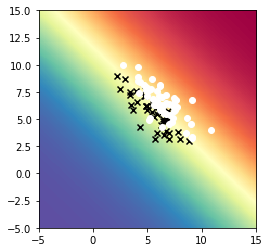

In [ ]:
plt.imshow(prediction, cmap='Spectral', interpolation='nearest', origin='lower', extent=[-5, 15, -5, 15])

pos = x_1[np.array(y_1 == 1).flatten()]
neg = x_1[np.array(y_1 == -1).flatten()]

plt.scatter(pos[:,0], pos[:,1], marker="x", color="black")
plt.scatter(neg[:,0], neg[:,1], marker="o", color="white")

In [ ]:
torch.cat((model(x_2), y_2), dim = 1)

In [ ]:
def binaryLRTest(X_t, y_t, model):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
      outputs = model(X_t)
      # the label with the highest energy will be our prediction
      total += labels.size(0)
      accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


### Robust Bias-Aware (RBA)


In [171]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import Adam

class RBAClassifier(nn.Module):
    def __init__(self, in_features = 2, out_features = 1):
      super(RBAClassifier, self).__init__()
      
      self.layer1 = nn.Linear(in_features, out_features, bias = True)

    def forward(self, input):
      return self.layer1(input)

In [172]:
class RBAGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, output, prob, y):
        ctx.save_for_backward(output, prob, y)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        output, prob, y = ctx.saved_tensors
        grad_temp = grad_output.clone()
        grad_input = grad_temp * (prob - y)
        return grad_input, None, None

In [204]:
def binaryRBATrain(X_s, y_s, r_st, r_ts, max_itr = 10000):

  rba_model = RBAClassifier(in_features = X_s.shape[1])
 
  optimizer = torch.optim.Adam(rba_model.parameters(), lr = 0.01)

  for param in rba_model.parameters():
    param.data = nn.parameter.Parameter(torch.ones_like(param))

  rba_model.train()

  # convert labels from -1, 1 to 0, 1
  if -1 in y_s:
    y_s = torch.FloatTensor(np.where(y_s == 1, 1, 0))

  n_row, _ = X_s.shape

  X_s *= r_ts

  for i in range(max_itr):  # loop over the dataset multiple times
      running_loss = 0.0
    
      optimizer.zero_grad()
      
      outputs = rba_model.forward(X_s)
      output_last = RBAGrad.apply(outputs, torch.sigmoid(outputs * r_st), y_s)
      output_last.backward(torch.ones(output_last.shape))

      # adjust parameters based on the calculated gradients
      optimizer.step()

  return rba_model

In [205]:
iw_model = binaryRBATrain(x_1_sec, y_1, torch.ones((x_1.shape[0], 1)), torch.Tensor(d_t / d_s).unsqueeze(1)) 

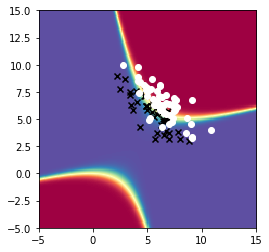

In [206]:
from matplotlib import markers
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

maxs = 15
mins = -5

X_dim1, X_dim2 = np.meshgrid(np.arange(mins, maxs + 0.1, 0.1), np.arange(mins, maxs + 0.1, 0.1))

dim = int((maxs - mins) / 0.1 + 1)

prediction = np.zeros((dim, dim))

for i in range(dim):
  for j in range(dim):
    x_t = torch.FloatTensor([X_dim1[i, j], X_dim2[i, j], X_dim1[i, j] ** 2, X_dim1[i, j] * X_dim2[i, j], X_dim2[i, j] ** 2])
    outputs = torch.sigmoid(iw_model(x_t))
    prediction[i, j] = outputs[0]

plt.imshow(prediction, cmap='Spectral', interpolation='nearest', origin='lower', extent=[-5, 15, -5, 15])

pos = x_1[np.array(y_1 == 1).flatten()]
neg = x_1[np.array(y_1 == -1).flatten()]

plt.scatter(pos[:,0], pos[:,1], marker="x", color="black")
plt.scatter(neg[:,0], neg[:,1], marker="o", color="white")

In [201]:
rba_model = binaryRBATrain(x_1, y_1, torch.Tensor(d_s / d_t).unsqueeze(1), torch.ones((x_1.shape[0], 1))) 

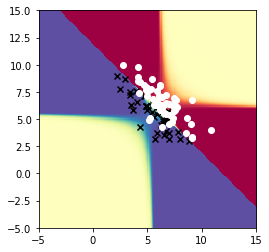

In [191]:
from matplotlib import markers
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

maxs = 15
mins = -5

X_dim1, X_dim2 = np.meshgrid(np.arange(mins, maxs + 0.1, 0.1), np.arange(mins, maxs + 0.1, 0.1))

dim = int((maxs - mins) / 0.1 + 1)

prediction = np.zeros((dim, dim))

for i in range(dim):
  for j in range(dim):
    x_t = torch.FloatTensor([X_dim1[i, j], X_dim2[i, j]])
    x_t = x_t.reshape((1, 2))
    outputs = torch.sigmoid(rba_model(x_t) * mvn_s.pdf(x_t) / mvn_t.pdf(x_t))
    prediction[i, j] = outputs[0]

plt.imshow(prediction, cmap='Spectral', interpolation='nearest', origin='lower', extent=[-5, 15, -5, 15])

pos = x_1[np.array(y_1 == 1).flatten()]
neg = x_1[np.array(y_1 == -1).flatten()]

plt.scatter(pos[:,0], pos[:,1], marker="x", color="black")
plt.scatter(neg[:,0], neg[:,1], marker="o", color="white")

### Text

In [ ]:
from scipy.stats import multivariate_normal

mvn_s = multivariate_normal(mu_s, var_s)
mvn_t = multivariate_normal(mu_t, var_t)

# Because we have expert knowledge on mu and var for both source and target, 
# we can get the predicted probabilities for each data point under source and target distributions 
d_s = mvn_s.pdf(x_1)
d_t = mvn_t.pdf(x_1)

In [ ]:
# RBA
theta_1 = binaryRobustTrain(x_1, y_1, d_s / d_t, np.ones((x_1.shape[0], 1)))
print("Weights", theta_1)

Optimizination stops by reaching maximum iteration
Weights [[11.91705313]
 [-1.00605443]
 [-1.0069282 ]]


In [ ]:
# Logistic Regression
theta_2 = binaryRobustTrain(x_1, y_1, np.ones((x_1.shape[0], 1)), np.ones((x_1.shape[0], 1)))
print("Weights", theta_2)

Optimization stops by reaching minimum gradient.
Weights [[12.35379291]
 [-1.04099695]
 [-1.0359673 ]]


In [ ]:
# Importance Weighting
r_ts = d_t / d_s
theta_3 = binaryRobustTrain(x_1, y_1, np.ones((x_1.shape[0], 1)), r_ts.reshape(r_ts.shape[0], 1))
print("Weights", theta_3)

Optimization stops by reaching minimum gradient.
Weights [[ 9.40884544]
 [-0.76023811]
 [-0.85193742]]


### Testing

In [ ]:
def binaryRobustTest(theta, X_t, y_t, r_st):
  n_row, _ = X_t.shape

  F = np.concatenate((np.ones((n_row, 1)), X_t), axis=1) 

  P = np.zeros((n_row, 1))
  logloss = 0
  prediction = np.zeros((n_row, 2))
  for i in range(n_row):
    W = r_st[i]
    temp =  (np.dot(np.transpose(theta), np.transpose(F[i, :])) * y_t[i] * W)[0]      
    temp_max = max(temp, -1 * temp)
    temp_min = min(temp, -1 * temp)
    P[i] = np.exp(temp - temp_max - np.log(1 + np.exp(temp_min - temp_max)))
    logloss = logloss - np.log(P[i])

    if y_t[i] == 1:
      prediction[i] = [P[i], 1 - P[i]]
    else:
      prediction[i] = [1 - P[i], P[i]]

  logloss = logloss / n_row / 0.6931
  return logloss, prediction

def computeAcc(pred, y):
  n_row, n_class = pred.shape
  
  max_ind = np.argmax(pred, axis = 1)

  summ = 0

  if n_class == 2:
    for i in range(n_row):
      if max_ind[i] == 1 and y[i] == -1:
        summ += 1
      elif max_ind[i] == 0 and y[i] == 1:
        summ += 1
  else:
    summ = sum(np.argmax(pred, axis = 1) == y_t - 1)

  return summ / n_row

In [ ]:
d_s = mvn_s.pdf(x_2)
d_t = mvn_t.pdf(x_2)

In [ ]:
# RBA
logloss_1, pred_1 = binaryRobustTest(theta_1, x_2, y_2, d_s / d_t)
print(logloss_1)

[0.82562143]


In [ ]:
logloss_2, pred_2 = binaryRobustTest(theta_2, x_2, y_2, np.ones((x_1.shape[0], 1)))
print(logloss_2)

[0.78499119]


In [ ]:
logloss_3, pred_3 = binaryRobustTest(theta_3, x_2, y_2, np.ones((x_1.shape[0], 1)))
print(logloss_3)

[0.69593336]


In [ ]:
print(computeAcc(pred_1, y_2))
print(computeAcc(pred_2, y_2))
print(computeAcc(pred_3, y_2))

0.89
0.9
0.87


## MultiClass Classification

In [ ]:
import scipy.io
import numpy as np
import os

folder_path = '/content' # TODO Change this

iris_train = scipy.io.loadmat(os.path.join(folder_path, 'iris_train.mat'))['iris_train']
iris_test = scipy.io.loadmat(os.path.join(folder_path, 'iris_test.mat'))['iris_test']

X_s = iris_train[:,0:-1]
y_s = iris_train[:, -1]
X_t = iris_test[:,0:-1]
y_t = iris_test[:,-1]

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(y_s)

Y_s = lb.transform(y_s)
Y_t = lb.transform(y_t)

X_s = torch.FloatTensor(X_s)
X_t = torch.FloatTensor(X_t)
Y_s = torch.FloatTensor(Y_s)
Y_t = torch.FloatTensor(Y_t)

n_row, n_col = X_s.shape

### Training


### Logistic Regression

In [ ]:
import torch


class MyLoss(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, y_pred, y):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        y_pred, y = ctx.saved_tensors
        grad_input = 
        return grad_input, None

SyntaxError: ignored

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

class MultiClassLR(nn.Module):
    def __init__(self, in_features = 4, out_features = 3):
      super(MultiClassLR, self).__init__()
      
      self.layer1 = nn.Linear(in_features, out_features, bias = False)
      self.activation1 = nn.Softmax(dim=1) # https://stackoverflow.com/questions/55675345/should-i-use-softmax-as-output-when-using-cross-entropy-loss-in-pytorch

    def forward(self, input):
      # return self.layer1(input)
      return self.activation1(self.layer1(input))



In [ ]:
def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss

In [ ]:
def LRDensityEstimation(X_s, X_t, lambdas = [0.0625, 1, 16]):

  np.random.seed(10) # seed set in matlab code as well for verification

  ns_row, _ = X_s.shape
  nt_row, _ = X_t.shape

  inda_s = np.arange(ns_row)
  inda_t = np.arange(nt_row)

  nv_s = int(np.floor(0.2 * ns_row))
  nv_t = int(np.floor(0.2 * nt_row))

  indv_s = np.array([92, 3, 74, 87, 57, 26, 23, 85, 19, 10, 75, 103, 1, 54, 111, 64, 116, 30, 118, 71, 105, 14, 36]) - 1 # indv_s = np.random.permutation(ns_row)[:nv_s] 

  indv_t = np.array([22, 14, 31, 18, 15, 29]) - 1 # np.random.permutation(nt_row)[:nv_t]

  indt_s = np.setdiff1d(inda_s, indv_s)
  
  indt_t = np.setdiff1d(inda_t, indv_t)

  X_train = np.concatenate((X_s[indt_s, :], X_t[indt_t, :]))
  X_valid = np.concatenate((X_s[indv_s, :], X_t[indv_t, :]))
  
  y_train = np.concatenate((np.ones((ns_row - nv_s, 1)), -1 * np.ones((nt_row - nv_t, 1)) ))
  y_valid = np.concatenate((np.ones((nv_s, 1)), -1 * np.ones((nv_t, 1)) ))

  rt_st = np.ones((ns_row + nt_row - nv_s - nv_t, 1))
  rv_st = np.ones((nv_s + nv_t, 1))
  
  logloss = np.zeros((len(lambdas), 1))
  for i, lamb in enumerate(lambdas):
    theta = binaryRobustTrain(X_train, y_train, rt_st, rt_st, lamb=lamb,min_gradient=0.1)
    _, pred = binaryRobustTest(theta, X_valid, y_valid, rv_st )
    logloss[i] = (-sum(np.log(pred[:nv_s, 0])) - sum(np.log(pred[nv_s: nv_s + nv_t, 1]))) / (nv_s + nv_t) / 0.6931

  ind_min = np.argmin(logloss)

  X_train = np.concatenate((X_s, X_t))
  y_train = np.concatenate((np.ones((ns_row, 1)), -1 * np.ones((nt_row, 1)) ))
  r_st = np.ones((ns_row + nt_row, 1))

  theta = binaryRobustTrain(X_train, y_train, r_st, r_st, lambdas[ind_min])
  _, pred = binaryRobustTest(theta, X_train, y_train, r_st)

  d_ss = pred[:ns_row, 0]
  d_st = pred[:ns_row, 1]

  d_ts = pred[ns_row:, 0]
  d_tt = pred[ns_row:, 1]

  print("Finish Density Estimation")

  return d_ss, d_st, d_ts, d_tt

In [ ]:
from torch.optim import Adam

# 
#
#
# 
def multiLRTrain(X_s, y_s, r_st, r_ts, max_itr = 10000):
  
  model = MultiClassLR()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=0.01)

  for param in model.parameters():
    param.data = nn.parameter.Parameter(torch.ones_like(param))

  
  model.train()

  n_row, n_col = X_s.shape
  X_s *= r_ts.repeat(1, n_col) * r_st.repeat(1, n_col)

  n_row, _ = X_s.shape

  # Define your execution device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("The model will be running on", device, "device")
  # Convert model parameters and buffers to CPU or Cuda
  model.to(device)

  for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data, param.grad)
  
  for epoch in range(max_itr):  # loop over the dataset multiple times
   
      # zero the parameter gradients
      optimizer.zero_grad()
      
      outputs = model(X_s) 

      # print(outputs)

      # print(torch.mm(torch.transpose(outputs - y_s, 0, 1), X_s) + 2 * multi_lr_model.layer1.weight)
      # print(torch.mm(torch.transpose(outputs - y_s, 0, 1), X_s) + 2 * multi_lr_model.layer1.weight)

      # compute the loss based on model output and real labels
      loss = loss_fn(outputs, y_s)
      # backpropagate the loss
      loss.backward()

      # for name, param in model.named_parameters():
      #   if param.requires_grad:
      #     print(name, param.data, param.grad)
  
      # adjust parameters based on the calculated gradients
      optimizer.step()
  
  return model

def multiLRTest(model, X_t, y_t):

  loss_fn = nn.NLLLoss()
  outputs = model(X_t)

  out, y_ind = torch.max(outputs, dim = 1)

  loss = -1 * sum(torch.log(out)) / len(X_t) / 0.6931

  return loss, outputs

def computeAcc(pred, y_t):
  out, ind = torch.max(pred, dim = 1)
  out, y_ind = torch.max(y_t, dim = 1)
  return torch.sum(ind == y_ind) / len(ind)

In [ ]:
multi_lr_model = multiLRTrain(X_s, Y_s, torch.ones((n_row, 1)), torch.ones(n_row, 1))
multi_iw_model = multiLRTrain(X_s, Y_s, torch.ones((n_row, 1)), torch.ones(n_row, 1))
multi_lr_model = multiLRTrain(X_s, Y_s, torch.ones((n_row, 1)), torch.ones(n_row, 1))

The model will be running on cpu device
layer1.weight tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]) None


In [ ]:
multi_lr_model.layer1.weight

Parameter containing:
tensor([[  8.0083,  17.0886, -16.0356, -16.3362],
        [ 13.3521,   5.7625, -15.5188,  -9.5025],
        [-12.2630, -20.7378,  23.4250,  17.7295]], requires_grad=True)

In [ ]:
for name, param in multi_lr_model.named_parameters():
  if param.requires_grad:
      print(name, param.data)

layer1.weight tensor([[  8.0083,  17.0886, -16.0356, -16.3362],
        [ 13.3521,   5.7625, -15.5188,  -9.5025],
        [-12.2630, -20.7378,  23.4250,  17.7295]])


In [ ]:
loss, outputs = multiLRTest(multi_lr_model, X_t, Y_t)
print(loss, outputs)

tensor(0.0188, grad_fn=<DivBackward0>) tensor([[9.9668e-01, 3.3231e-03, 0.0000e+00],
        [9.9989e-01, 1.1287e-04, 0.0000e+00],
        [9.9977e-01, 2.2762e-04, 0.0000e+00],
        [9.9999e-01, 6.3643e-06, 0.0000e+00],
        [9.9999e-01, 1.4322e-05, 0.0000e+00],
        [9.9994e-01, 6.4556e-05, 0.0000e+00],
        [9.9929e-01, 7.1479e-04, 0.0000e+00],
        [9.9943e-01, 5.7084e-04, 0.0000e+00],
        [9.9998e-01, 2.3348e-05, 0.0000e+00],
        [9.9901e-01, 9.8560e-04, 0.0000e+00],
        [9.9994e-01, 5.8397e-05, 0.0000e+00],
        [1.0000e+00, 6.1048e-07, 0.0000e+00],
        [9.9997e-01, 2.7263e-05, 0.0000e+00],
        [9.9373e-01, 6.2693e-03, 0.0000e+00],
        [9.9973e-01, 2.6660e-04, 0.0000e+00],
        [9.9987e-01, 1.3179e-04, 0.0000e+00],
        [9.9930e-01, 6.9761e-04, 0.0000e+00],
        [9.9943e-01, 5.7084e-04, 0.0000e+00],
        [9.9947e-01, 5.3232e-04, 0.0000e+00],
        [9.9943e-01, 5.7084e-04, 0.0000e+00],
        [9.9978e-01, 2.1881e-04, 0.0000e+

In [ ]:
torch.cat((outputs, Y_t), dim = 1)

tensor([[9.9668e-01, 3.3231e-03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9989e-01, 1.1287e-04, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9977e-01, 2.2762e-04, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9999e-01, 6.3643e-06, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9999e-01, 1.4322e-05, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9994e-01, 6.4556e-05, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9929e-01, 7.1479e-04, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9943e-01, 5.7084e-04, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9998e-01, 2.3348e-05, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9901e-01, 9.8560e-04, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9994e-01, 5.8397e-05, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 6.1048e-07, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9997e

In [ ]:
computeAcc(outputs, Y_t)

tensor(0.9688)

In [ ]:
multi_lr_model(torch.FloatTensor(X_s))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor([[-0.3333, -1.4788, -2.8912],
        [-0.3350, -1.4956, -2.8047],
        [-0.3168, -1.5063, -3.0001],
        [-0.2336, -1.7227, -3.5143],
        [-0.2167, -1.8353, -3.3443],
        [-0.2748, -1.6302, -3.1155],
        [-0.3518, -1.4422, -2.8109],
        [-0.3595, -1.4002, -2.8920],
        [-0.2947, -1.6042, -2.9153],
        [-0.4347, -1.2592, -2.6783],
        [-0.3359, -1.5012, -2.7730],
        [-0.5200, -1.1759, -2.3338],
        [-0.3558, -1.4240, -2.8371],
        [-0.3652, -1.3928, -2.8546],
        [-0.4392, -1.2510, -2.6707],
        [-0.2118, -1.8705, -3.3005],
        [-0.2079, -1.8638, -3.4238],
        [-0.3406, -1.4205, -3.0561],
        [-0.3768, -1.3843, -2.7572],
        [-0.3804, -1.4402, -2.5313],
        [-0.2931, -1.6089, -2.9197],
        [-0.3113, -1.5295, -2.9784],
        [-2.5670, -0.6350, -0.9331],
        [-2.4641, -0.7460, -0.8195],
        [-2.8375, -0.6925, -0.8184],
        [-2.6665, -0.7558, -0.7746],
        [-2.8594, -0.7070, -0.7994],
 

In [ ]:
def LRDensityEstimation(X_s, X_t, lambdas = [0.0625, 1, 16]):

  np.random.seed(10) # seed set in matlab code as well for verification

  ns_row, _ = X_s.shape
  nt_row, _ = X_t.shape

  inda_s = np.arange(ns_row)
  inda_t = np.arange(nt_row)

  nv_s = int(np.floor(0.2 * ns_row))
  nv_t = int(np.floor(0.2 * nt_row))

  indv_s = np.array([92, 3, 74, 87, 57, 26, 23, 85, 19, 10, 75, 103, 1, 54, 111, 64, 116, 30, 118, 71, 105, 14, 36]) - 1 # indv_s = np.random.permutation(ns_row)[:nv_s] 

  indv_t = np.array([22, 14, 31, 18, 15, 29]) - 1 # np.random.permutation(nt_row)[:nv_t]

  indt_s = np.setdiff1d(inda_s, indv_s)
  
  indt_t = np.setdiff1d(inda_t, indv_t)

  X_train = np.concatenate((X_s[indt_s, :], X_t[indt_t, :]))
  X_valid = np.concatenate((X_s[indv_s, :], X_t[indv_t, :]))
  
  y_train = np.concatenate((np.ones((ns_row - nv_s, 1)), -1 * np.ones((nt_row - nv_t, 1)) ))
  y_valid = np.concatenate((np.ones((nv_s, 1)), -1 * np.ones((nv_t, 1)) ))

  rt_st = np.ones((ns_row + nt_row - nv_s - nv_t, 1))
  rv_st = np.ones((nv_s + nv_t, 1))
  
  logloss = np.zeros((len(lambdas), 1))
  for i, lamb in enumerate(lambdas):
    theta = binaryRobustTrain(X_train, y_train, rt_st, rt_st, lamb=lamb,min_gradient=0.1)
    _, pred = binaryRobustTest(theta, X_valid, y_valid, rv_st )
    logloss[i] = (-sum(np.log(pred[:nv_s, 0])) - sum(np.log(pred[nv_s: nv_s + nv_t, 1]))) / (nv_s + nv_t) / 0.6931

  ind_min = np.argmin(logloss)

  X_train = np.concatenate((X_s, X_t))
  y_train = np.concatenate((np.ones((ns_row, 1)), -1 * np.ones((nt_row, 1)) ))
  r_st = np.ones((ns_row + nt_row, 1))

  theta = binaryRobustTrain(X_train, y_train, r_st, r_st, lambdas[ind_min])
  _, pred = binaryRobustTest(theta, X_train, y_train, r_st)

  d_ss = pred[:ns_row, 0]
  d_st = pred[:ns_row, 1]

  d_ts = pred[ns_row:, 0]
  d_tt = pred[ns_row:, 1]

  print("Finish Density Estimation")

  return d_ss, d_st, d_ts, d_tt

d_ss, d_st, d_ts, d_tt = LRDensityEstimation(X_s, X_t, [0.1, 1, 10])

Optimization stops by reaching minimum gradient.
Optimization stops by reaching minimum gradient.
Optimization stops by reaching minimum gradient.
Optimization stops by reaching minimum gradient.
Finish Density Estimation


In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

def multiClassRobustTrain(X_s, y_s, n_class, r_st, r_ts, lamb = 0.1, lr = 0.01, max_itr = 100000, min_gradient = 0.001):
  n_row, n_col = X_s.shape

  lamb = lamb.reshape(-1, 1)  
  lamb = np.transpose(np.tile(lamb, n_class))
  
  F = X_s 

  F_g = F * np.tile(r_ts, n_col)

  Y = lb.fit_transform(y_s)

  P = np.zeros((n_row, n_class)) 

  S_g = np.ones((n_class, n_col)) * 1e-8

  t = 1

  theta = np.ones((n_class, n_col)) # not randomly assigned? 

  l_0 = 0

  l_1 = (1 + (1 + (4 * l_0 ** 2)) ** 0.5) / 2
  delta_1 = 0

  while True:
    t = t + 1
    decay = np.sqrt(1000 / (1000 + t))
    l_2 = (1 + (1 + (4 * l_1 ** 2)) ** 0.5) / 2
    l_3 = (1 - l_1) / l_2

    for i in range(n_row):
      W = r_st[i]
      temp =  np.dot(theta, np.transpose(F[i, :])) * W
      temp = temp - np.max(temp)
      sum_temp = sum(np.exp(temp))
      P[i] = np.exp(temp - np.log(sum_temp))

    G = np.dot(np.transpose(P) - np.transpose(Y), F_g) + 2 * lamb * theta

    if np.linalg.norm(G) < min_gradient:
      print('Optimization stops by reaching minimum gradient.')
      break
    elif t > max_itr:
      print("Optimizination stops by reaching maximum iteration")
      break

    S_g = S_g + G ** 2
    delta_2 = theta - decay * lr * G / np.sqrt(S_g) 
    theta = np.dot((1 - l_3), delta_2) + np.dot(l_3, delta_1)
    delta_1 = delta_2
    l_1 = l_2
    
  return theta

In [ ]:
# RBA

ns_row, n_col = X_s.shape

n_class = int(max(y_s))

lamb = 2 * np.std(X_s, axis=0, ddof=1) / np.sqrt(ns_row)
lamb[0] = 1

theta_robust = multiClassRobustTrain(X_s, y_s, n_class, d_ss / d_st, np.ones((ns_row, 1)), lamb=lamb, lr = 1, min_gradient=0.01)

Optimization stops by reaching minimum gradient.


In [ ]:
# Logistic Regression
theta_lr = multiClassRobustTrain(X_s, y_s, n_class, np.ones((ns_row, 1)), np.ones((ns_row, 1)), lamb=lamb, lr = 1, min_gradient=0.01)

Optimization stops by reaching minimum gradient.


In [ ]:
# Importance weighting
r_ts = np.reshape(d_st / d_ss, (-1, 1))
theta_iw = multiClassRobustTrain(X_s, y_s, n_class, np.ones((ns_row, 1)), r_ts, lamb=lamb, lr = 1, min_gradient=0.01)

Optimization stops by reaching minimum gradient.


### Testing

In [ ]:
def multiClassRobustTest(theta, X_t, y_t, n_class, r_st):
  n_row, _ = X_t.shape
  F = X_t 
  P = np.zeros((n_row, n_class))
  logloss = 0 

  for i in range(n_row):
      W = r_st[i]
      temp =  np.dot(theta, np.transpose(F[i, :])) * W
      temp = temp - np.max(temp)
      sum_temp = sum(np.exp(temp))
      P[i] = np.exp(temp - np.log(sum_temp))
      logloss -= np.log(P[i, int(y_t[i]) - 1])

  logloss = logloss / n_row / 0.6931
  return logloss, P

In [ ]:
logloss, pred = multiClassRobustTest(theta_robust, X_t, y_t, n_class, d_ts / d_tt)
acc = computeAcc(pred, y_t)
print(f'Acc is {acc} and logloss is {logloss} for robust method')

Acc is 1.0 and logloss is 0.4989368812192846 for robust method


In [ ]:
logloss, pred = multiClassRobustTest(theta_lr, X_t, y_t, n_class, np.ones((ns_row, 1)))
acc = computeAcc(pred, y_t)
print(f'Acc is {acc} and logloss is {logloss} for LR method')

Acc is 1.0 and logloss is 0.09988054970933052 for LR method


In [ ]:
logloss, pred = multiClassRobustTest(theta_iw, X_t, y_t, n_class, np.ones((ns_row, 1)))
acc = computeAcc(pred, y_t)
print(f'Acc is {acc} and logloss is {logloss} for IW method')

Acc is 0.96875 and logloss is 0.17910794400844812 for IW method
